In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# ex1

trend = lambda x : 100 * (x - 0.5) ** 2
sezon = lambda x: np.sin(2 * np.pi * 5 * x) + np.sin(2 * np.pi * 7 * x)
variatii = lambda x:  np.random.normal(0,1,len(x))

N = 1000
time = np.linspace(0, 1, N)
t = trend(time)
s = sezon(time)
v = variatii(time)

signal = t + s + v 



/var/folders/xv/w6vjg90x4pd72d9mbrnc1v6h0000gn/T/ipykernel_1966/3853855804.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


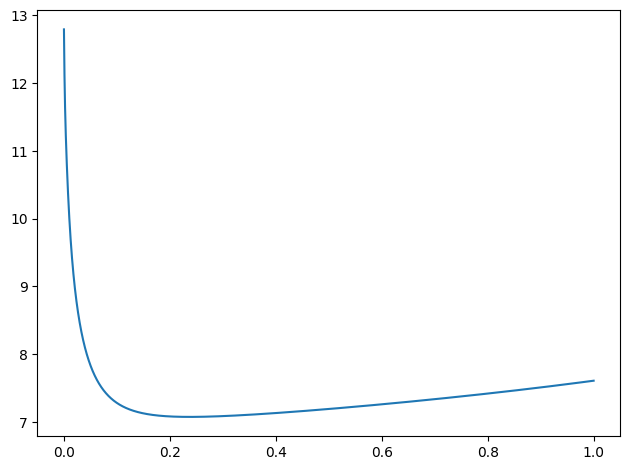

In [17]:
# ex2

def exponentialAverage(signal, alfa):
    s = [signal[0]]
    
    for x in signal[1:]:
        s.append(alfa * x + (1 - alfa) * s[-1])
        
    return s 

fig, axs = plt.subplots(2)
axs[0].plot(signal)
axs[1].plot(exponentialAverage(signal, 0.237))

fig.tight_layout()
fig.savefig("ex2_smoothed_signal.pdf")
fig.show()

def mse(x, s):
    return np.sum((x[1:] - s[:-1]) ** 2)

optimalAlfa = 0
minimumMse = np.inf
mseResults = []
alfas = np.linspace(0, 1, 10000)
for alfa in alfas:
    expSignal = exponentialAverage(signal, alfa)
    mseResults.append(mse(signal, expSignal))
    
    if mseResults[-1] < minimumMse:
        minimumMse = mseResults[-1]
        optimalAlfa = alfa
        
plt.clf()
plt.plot(alfas, np.log(mseResults))
plt.savefig("ex2_alfas.pdf")
plt.show()
    

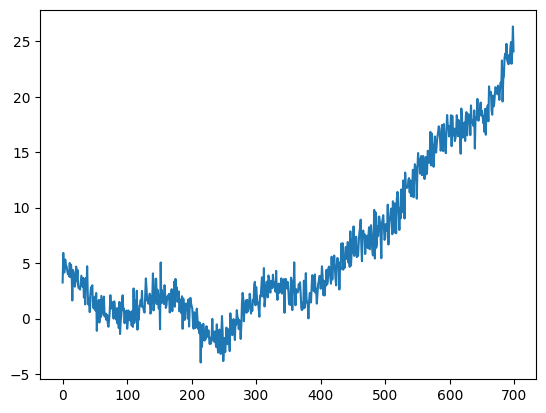

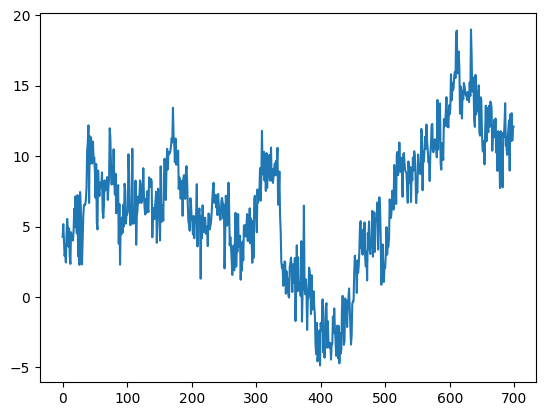

In [33]:
# ex3

p = 300
eps = np.random.normal(0, 1, len(signal))
A = eps[0: p]
for i in range(1, len(signal) - p):
    A = np.row_stack((A, eps[i : i + p]))
    
theta = np.linalg.lstsq(A, signal[p:], rcond=None)[0]

y_ma = A @ theta 
y_ma = y_ma + np.random.normal(0, 1, y_ma.size) + np.mean(signal[p:])

plt.plot(signal[p:])
plt.savefig("ex3_original_signal.pdf")
plt.show()
plt.plot(y_ma)
plt.savefig("ex3_reconstructed_signal.pdf")
plt.show()